# Regularized Logistic Regression and SGD

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd
import random
import seaborn as sns

## 1) Mini-Batch Gradient Descent

Consider a univariate logistic regression where we are trying to predict $Y$, which can take the value $0$ or $1$, from the variable $X$, which takes real values. We need to estimate parameters $\beta_{0}$ and $\beta_{1}$ by minimizing the penalized loss function (we rewrite the binary cross entropy loss a little bit to make the calculations easier):

$\mathcal{L}(\beta_{0}, \beta_{1}) = \frac{1}{n}\sum\limits_{i=1}^{n} \left[ log\left( 1 + e^{\beta_{0} + X_{i}\beta_{1}}\right) - Y_{i}\left(\beta_{0} + X_{i}\beta_{1}\right)\right] + \lambda \beta_{1}^{2}$ .

*(Note that generally the intercept is not penalized.)*

In this problem, we will implement mini-batch gradient descent. At each iteration, a random set of $m$ samples from all $n$ samples is used to calculate the loss and gradient, which is the change in the loss with respect to the parameters. We then update the estimates of $\beta_{0}$ and $\beta_{1}$ based on the gradient.

We use a toy dataset using the parameter values of $\beta_{0} = 3$ and $\beta_{1} = -5$.

In [2]:
n = 10000 
np.random.seed(265)
x1 = np.random.uniform(-5, 5, size=n) 
beta0 = 3
beta1 = -5
p = np.exp(beta0 + x1*beta1)/(1 + np.exp(beta0 + beta1*x1)) 
y = np.random.binomial(1, p, size=n) 

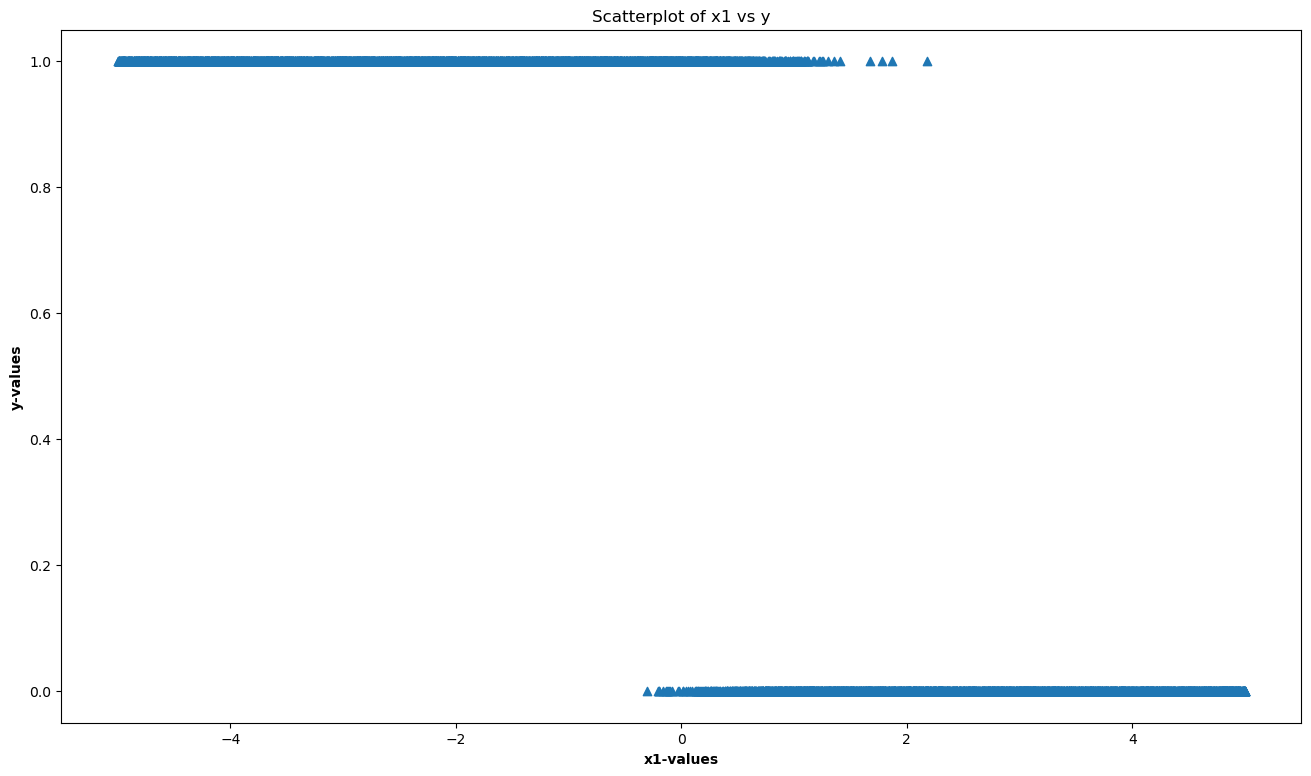

In [3]:
fig = plt.figure(figsize = (16, 9))

sct1 = plt.scatter(x1, y, marker ='^')

plt.title("Scatterplot of x1 vs y")
plt.xlabel('x1-values', fontweight ='bold')
plt.ylabel('y-values', fontweight ='bold')

plt.show()

In [4]:
# Helper function that we will use to visualize the training process

def plot_betas_and_loss(beta0_all, beta1_all, loss_all, title=''):
    fig, ax = plt.subplots(1, 3, figsize=(18,5))
    ax[0].plot(np.arange(len(beta0_all)), beta0_all)
    ax[0].hlines(beta0, xmin=0, xmax=len(beta0_all),color = 'r')
    ax[0].set_xlabel("Iteration", fontsize=12)
    ax[0].set_ylabel(r"$\widehat{\beta}_{0}$", fontsize=12)

    ax[1].plot(np.arange(len(beta1_all)), beta1_all)
    ax[1].hlines(beta1, xmin=0, xmax=len(beta1_all),color = 'r')
    ax[1].set_xlabel("Iteration", fontsize=12)
    ax[1].set_ylabel(r"$\widehat{\beta}_{1}$", fontsize=12)
    ax[1].set_title(title)

    ax[2].plot(np.arange(len(loss_all)), loss_all)
    ax[2].set_xlabel("Iteration", fontsize=12)
    ax[2].set_ylabel("Loss", fontsize=12)
    plt.show()

### 1.a) Deriving the gradients

For given values of $\beta_{0}$ and $\beta_{1}$ the vector $\left( \dfrac{\partial}{\partial \beta_{0}} \mathcal{L}_{t}(\beta_{0}, \beta_{1}), \dfrac{\partial}{\partial \beta_{1}} \mathcal{L}_{t}(\beta_{0}, \beta_{1}) \right)^{T}$ is called the gradient of $\mathcal{L}_{t}(\beta_{0}, \beta_{1})$ and is denoted $\nabla \mathcal{L}_{t}(\beta_{0}, \beta_{1})$.

The derivative of $\mathcal{L}_{t}(\beta_{0}, \beta_{1})$ with respect to $\beta_{0}$, treating $\beta_{1}$ as a constant (i.e. $\dfrac{\partial}{\partial \beta_{0}} \mathcal{L}_{t}(\beta_{0}, \beta_{1})$): 


$\dfrac{\partial}{\partial \beta_{0}} \mathcal{L}_{t}(\beta_{0}, \beta_{1}) = \frac{1}{m}\sum\limits_{i=1}^{m} \left[ \left( \frac{1}{1 + e^{\beta_{0} + X_{i}\beta_{1}}} e^{\beta_{0} + X_{i}\beta_{1}}\right) - Y_{i}\right]$



$ \Rightarrow \dfrac{\partial}{\partial \beta_{0}} \mathcal{L}_{t}(\beta_{0}, \beta_{1}) = \frac{1}{m}\sum\limits_{i=1}^{m} \left[ \left( \frac{1}{1 + e^{-(\beta_{0} + X_{i}\beta_{1})}}\right) - Y_{i}\right]$


The derivative of $\mathcal{L}_{t}(\beta_{0}, \beta_{1})$ with respect to $\beta_{1}$, treating $\beta_{0}$ as a constant. (i.e. $\dfrac{\partial}{\partial \beta_{1}} \mathcal{L}_{t}(\beta_{0}, \beta_{1})$):

$\dfrac{\partial}{\partial \beta_{0}} \mathcal{L}_{t}(\beta_{0}, \beta_{1}) = \frac{1}{m}\sum\limits_{i=1}^{m} \left[ \left( \frac{1}{1 + e^{\beta_{0} + X_{i}\beta_{1}}} e^{\beta_{0} + X_{i}\beta_{1}} X_{i} \right) - Y_{i} X_{i} \right] + 2 \lambda \beta_{1} $



$ \Rightarrow \dfrac{\partial}{\partial \beta_{0}} \mathcal{L}_{t}(\beta_{0}, \beta_{1}) = \frac{1}{m}\sum\limits_{i=1}^{m} \left[ \left( \frac{1}{1 + e^{-(\beta_{0} + X_{i}\beta_{1})}} X_{i} \right) - Y_{i} X_{i} \right] + 2 \lambda \beta_{1} $

When we implement mini-batch stochastic gradient descent, we will use these formulas, but 
apply them to a mini-batch of $m$ randomly chosen datapoints, rather than to all $n$ datapoints 
(in our case $n=10,000$).
Typically $m$ is chosen to be much, much smaller than $n$.




### 1.b) Writing the update function

In [5]:
def update(b0, b1, inds, step_size, lamb):
    m = len(inds)
    x1_upd = x1[inds]
    y_upd = y[inds]

    L_partial0 = (1 / m) * np.sum((1 / (1 + np.exp(-(b0 + x1_upd*b1)))) - y_upd)
    L_partial1 = ((1 / m) * np.sum((x1_upd / (1 + np.exp(-(b0 + x1_upd*b1)))) 
                                 - np.multiply(x1_upd, y_upd)) + 2 * lamb*b1)
    
    b0 -= step_size * L_partial0
    b1 -= step_size * L_partial1
    return (b0, b1)

We also write the function `loss` which takes values for $\beta_{0}$ and $\beta_{1}$,
together with a subset of indices and regularization parameter, and returns the value of the loss function evaluated at those data points.

In [6]:
def loss(b0, b1, inds, lamb):
    m = len(inds)
    x1_upd = x1[inds]
    y_upd = y[inds]

    output = ((1/m) * np.sum(np.log(1 + np.exp(b0 + x1_upd * b1)) 
                             - np.multiply(y_upd, b0 + x1_upd * b1)) 
               + lamb * b1**2)

    return output

### 1.c) Putting it all together 

In [7]:
def minibatch_grad_descent(b0=0, b1=0, batch_size=100, step_size=10, lamb=0, iterations=1000):
    beta0_hat = b0
    beta1_hat = b1
    beta0_all = []
    beta1_all = []
    loss_all = []

    for iter in range(iterations):   
        inds = random.sample(range(n), batch_size)
        batch_loss = loss(beta0_hat, beta1_hat, inds, lamb)
        beta0_hat, beta1_hat = update(beta0_hat, beta1_hat, inds, step_size, lamb)

        beta0_all.append(beta0_hat)
        beta1_all.append(beta1_hat)
        loss_all.append(batch_loss)
        iter = iter+1
        
    return (beta0_hat, beta1_hat, beta0_all, beta1_all, loss_all)

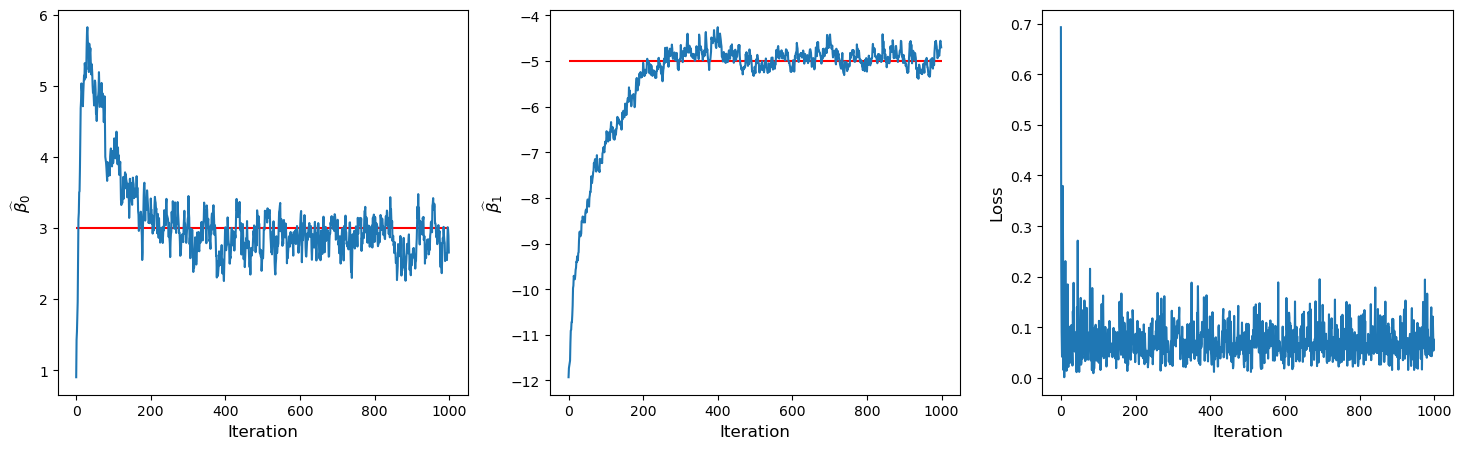

In [8]:
beta0_hat, beta1_hat, beta0_all, beta1_all, loss_all = minibatch_grad_descent()
plot_betas_and_loss(beta0_all, beta1_all, loss_all)

## Part d: Assessing uncertainty


In [9]:
from tqdm import tqdm

beta0_hat_all_0 = []
beta1_hat_all_0 = []
for rep in tqdm(range(30)):
    beta0_hat, beta1_hat, _, _, _ = minibatch_grad_descent()
    beta0_hat_all_0.append(beta0_hat)
    beta1_hat_all_0.append(beta1_hat)
    
print('The mean of the estimated beta0 is %.2f' % np.mean(beta0_hat_all_0))
print('The standard deviation of the estimated beta0 is %.3f' % np.std(beta0_hat_all_0))
print('The mean of the estimated beta1 is %.2f' % np.mean(beta1_hat_all_0))
print('The standard deviation of the estimated beta1 is %.3f' % np.std(beta1_hat_all_0))

100%|███████████████████████████████████████████| 30/30 [00:03<00:00,  8.42it/s]

The mean of the estimated beta0 is 2.92
The standard deviation of the estimated beta0 is 0.204
The mean of the estimated beta1 is -4.90
The standard deviation of the estimated beta1 is 0.151


In [10]:
print(np.mean(beta0_hat_all_0) -1.96 * np.std(beta0_hat_all_0))
print(np.mean(beta0_hat_all_0) +1.96 * np.std(beta0_hat_all_0))
print(np.mean(beta1_hat_all_0) -1.96 * np.std(beta1_hat_all_0))
print(np.mean(beta1_hat_all_0) +1.96 * np.std(beta1_hat_all_0))

2.5154423330027025
3.316322659473871
-5.194165966693464
-4.6038554273115855


Every time the mini-batch gradient descent algorithm is ran, another solution for $\beta_0$ and $\beta_1$ will be generated, even though the initial values are the same for each of the 30 runs. This is due to the randomness of the batches in each iteration inside a run, being m (=100) random samples out of n (=10,000) total samples. In each iteration, another random batch is generated. As one run has 1000 iterations, the chances of the algorithm generating the same solution is almost 0. This is the reason why there is a variation in the estimates.

To calculate a 95%-confidence interval, it will be assumed that the $\beta$-values are approximately standard normally distributed. The critical value for a 95%-confidence interval, denoted by $z_{0.025}$, is equal to 1.96. The confidence intervals for $\beta_0$ and $\beta_1$ are respectively given by:

$ \beta_0 \in \left[ \overline{\hat{\beta_0}} - z_{0.025} \cdot s_{\hat{\beta_0}}, \overline{\hat{\beta_0}} + z_{0.025} \cdot s_{\hat{\beta_0}}\right]$
$ \Rightarrow \beta_0 \in \left[ 2.473, 3.238 \right]$

$ \beta_1 \in \left[ \overline{\hat{\beta_1}} - z_{0.025} \cdot s_{\hat{\beta_1}}, \overline{\hat{\beta_1}} + z_{0.025} \cdot s_{\hat{\beta_1}}  \right]$
$ \Rightarrow \beta_1 \in \left[ -5.283, -4.402 \right]$

The true parameters, being $\beta_0$ = 3 and $\beta_1$ = -5, fall within these confidence intervals. 

### 1.e) Influence of the mini-batch  sizes

We repeat Part c with different $m$ (the size of the mini-batches), e.g. $m=1000$, $m=100$, and $m=10$. We use (0,0) as the initial estimates of $\beta_{0}$ and $\beta_{1}$. Plot $\beta_{0}$, $\beta_{1}$, and $\mathcal{L}(\beta_{0}, \beta_{1})$ vs. iteration number.

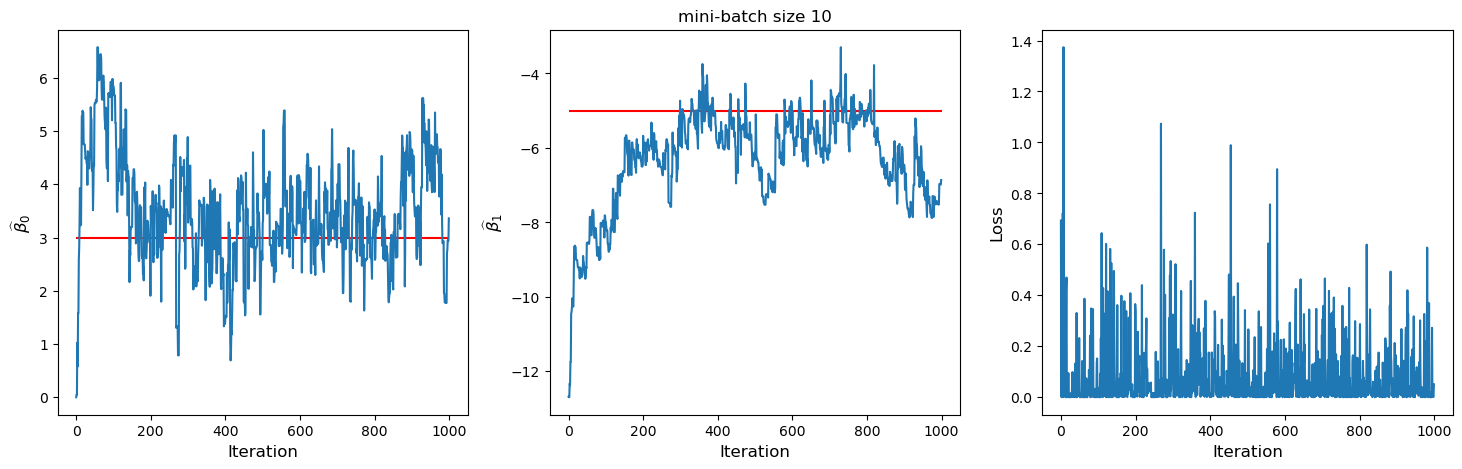

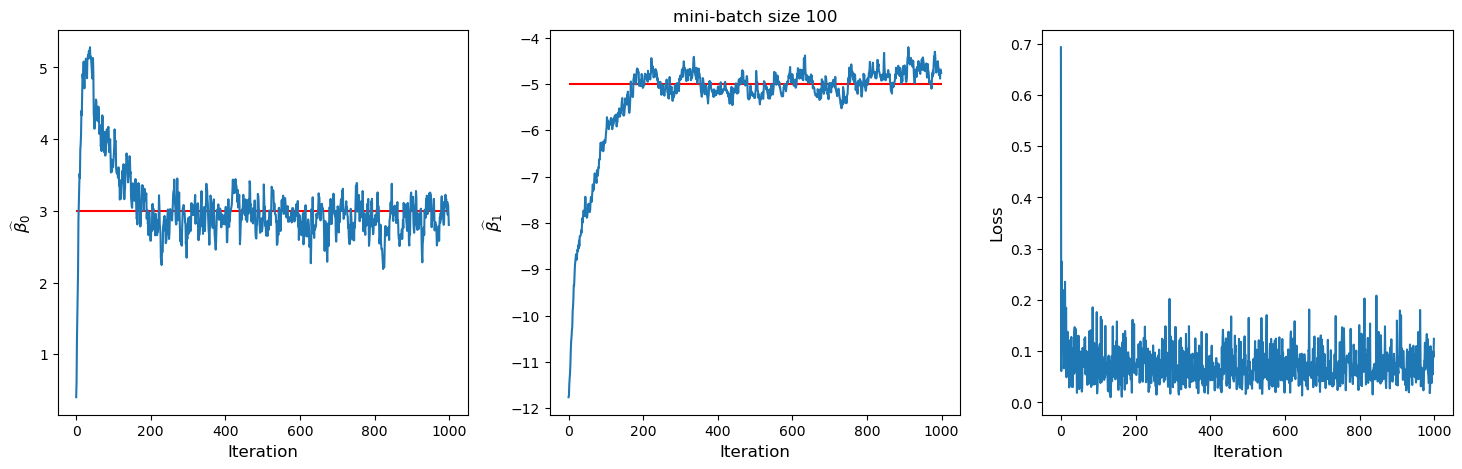

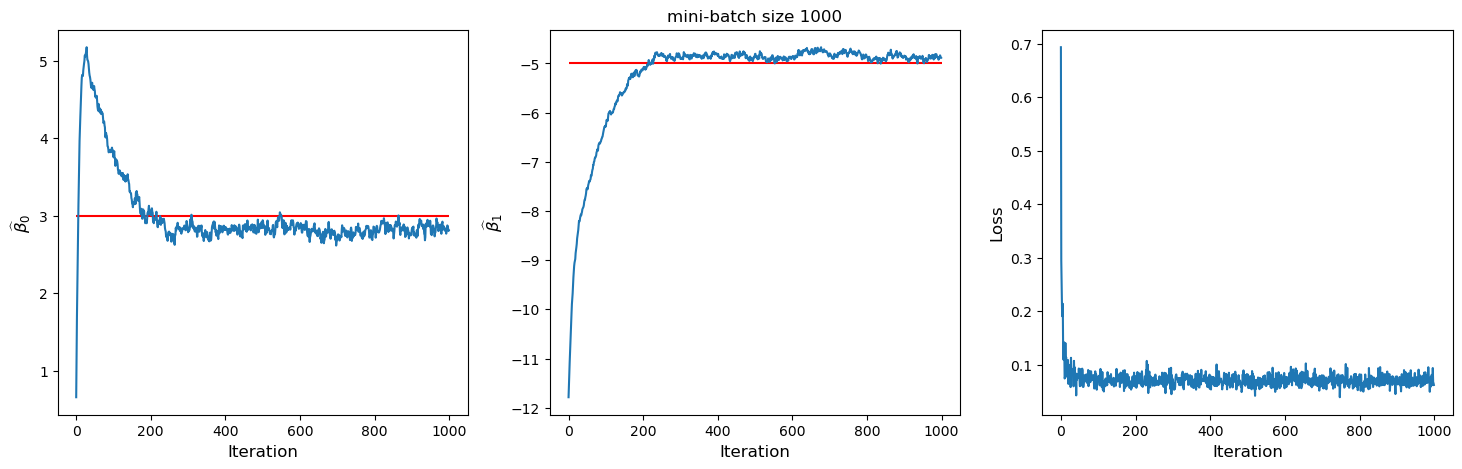

In [11]:
for batch_size in [10, 100, 1000]:
    _, _, beta0_all, beta1_all, loss_all = minibatch_grad_descent(batch_size=batch_size)
    plot_betas_and_loss(beta0_all, beta1_all, loss_all, title='mini-batch size %d' % batch_size)

After investigating the different plots, one can conclude that batch size impacts the accuracy of the estimates, as well as the stability of the learning process. Smaller batch sizes tend to be noisy, having a volatile learning process with higher variance. This was expected as more randomness is created, giving more variation between the iteration steps. Larger batch sizes tend to slow down the learning process (higher running time as it is more computationally expensive), but give a more stable result, characterized by lower variance or noise. This was also expected, as there is less variation between the different iteration steps. 

Therefore, it is not advised to choose a too small batch size. A too low batch size (in this case m = 10) has to much variation in the iteration process, leading to a lesser convergence in the result. This means that the estimates will highly depend on when the iteration stops. One can also see that the iteration plot of m = 10 does not fluctuates around the true values of the parameters, so doing repeatable runs and taking the mean will not lead to an accurate result. Higher batch sizes will better capture the gradients in the mini batch GD algorithm, leading to a more stable result with better convergence. As a consequence, a higher batch size is recommended. One should, however, also take computational speed in account. Higher batch sizes can slow down the algorithm, hence one should find a balance between computational speed and batch size. In this exercise, however, the problem is not very complex as only two parameters need to be calculated. As a consequence, one can conclude that the run with mini batch size m = 1000 gives the best results.

### 1.f) Comparing regularization levels $\lambda$ 

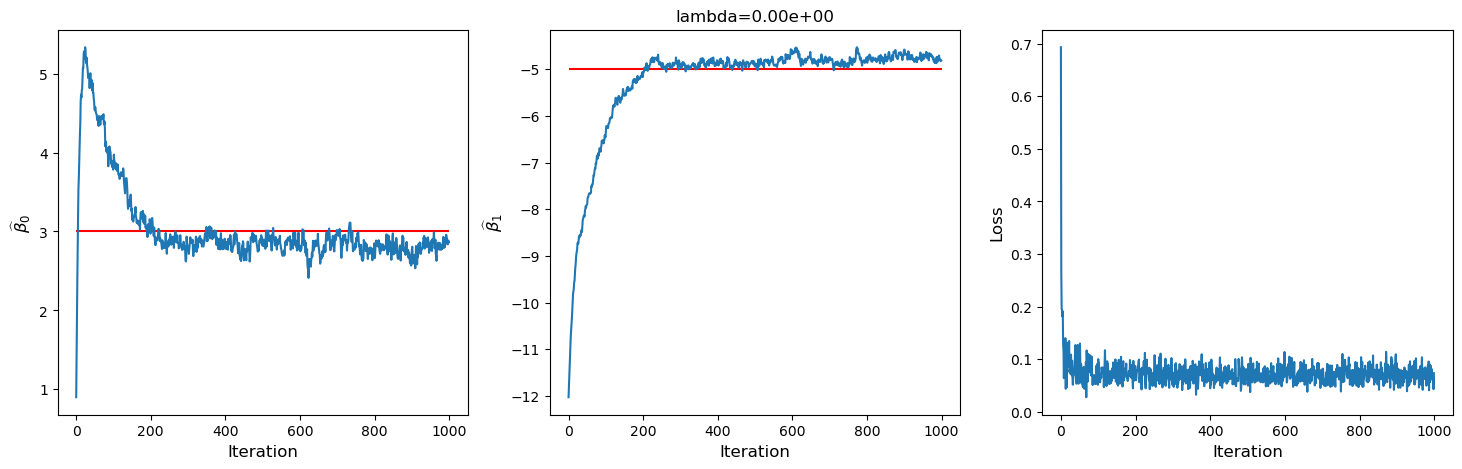

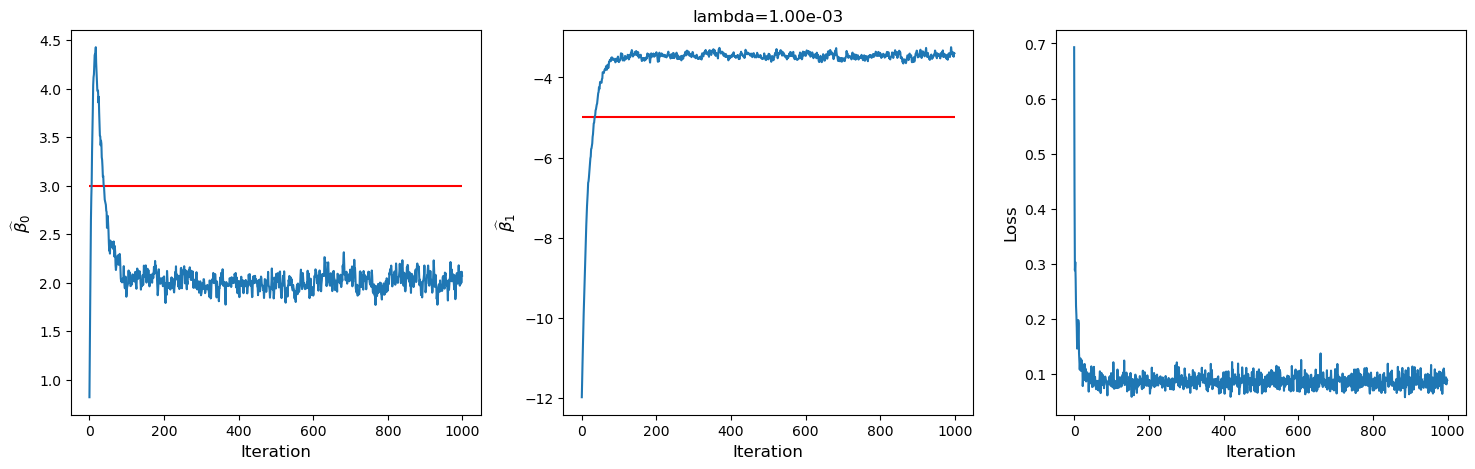

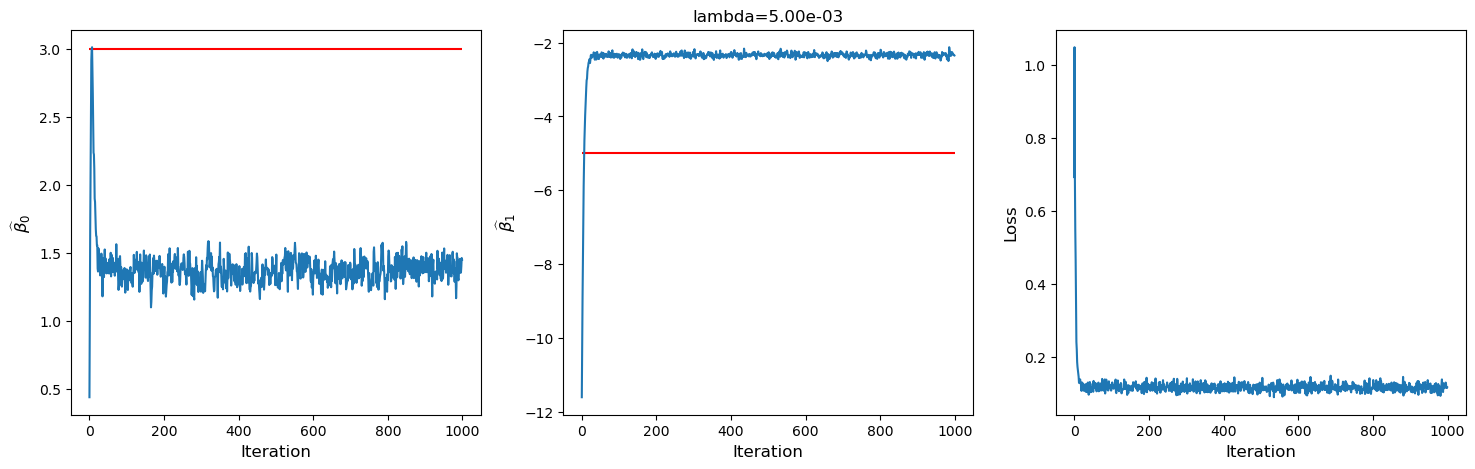

In [12]:
for lamb in [0, .001, .005]:
    _, _, beta0_all, beta1_all, loss_all = minibatch_grad_descent(batch_size=500, lamb=lamb)
    plot_betas_and_loss(beta0_all, beta1_all, loss_all, title = 'lambda=%.2e' % lamb)

Generally speaking, a potential issue of stochastic gradient descent is the danger of overfitting the parameters to the training data. This overfitting may result in a significant generalization error (out of sample error or test error) and bad performance on unseen data. To solve this issue, a regularization term or penalty term (with regularization parameter $\lambda$) can be added to the loss function. In this case, if the absolute value of $\beta_1$ gets too large, this will increase the loss function, which will prevent the algorithm from further increasing $\beta_1$ and tell it to decrease $\beta_1$ (because the algorithm tends to go in the direction of decreasing loss). This will also affect $\beta_0$.

The reason why the algorithm generates other values for $\beta_0$ and $\beta_1$ is because the algorithm found another minimum, but it is not the desired minimum. The higher the penalty term $\lambda$, the closer the algorithm's solutions for $\beta$ are to zero. This was expected, as the penalty term in the loss function shrinks the values of $\beta$. A higher $\lambda$ also leads to less variance (or fluctuation) in between the iteration steps.

### 1.g) Comparing step sizes $\eta$

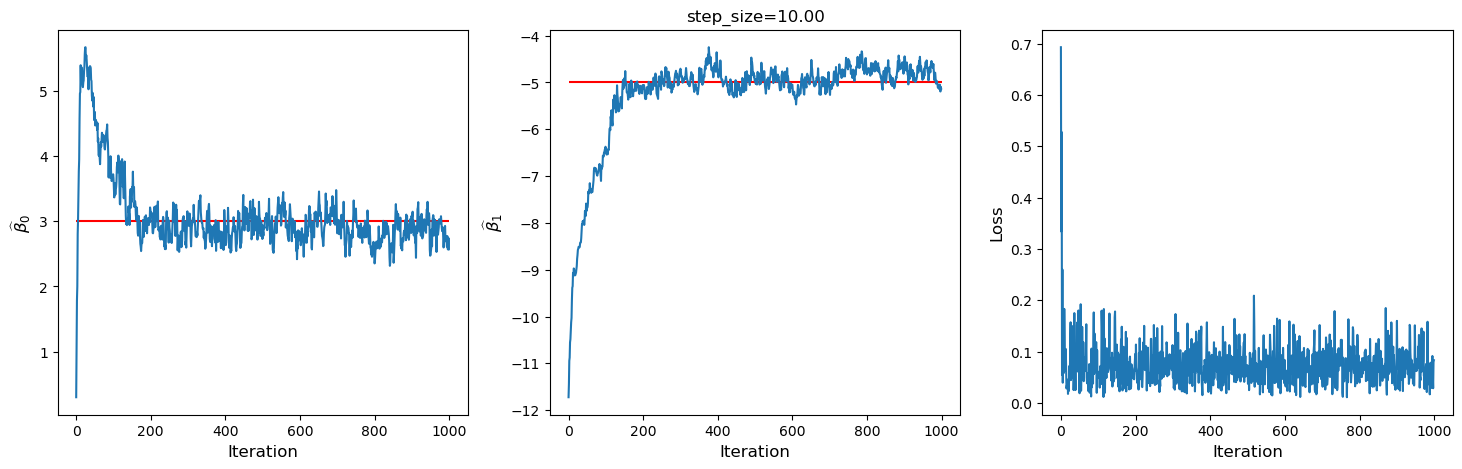

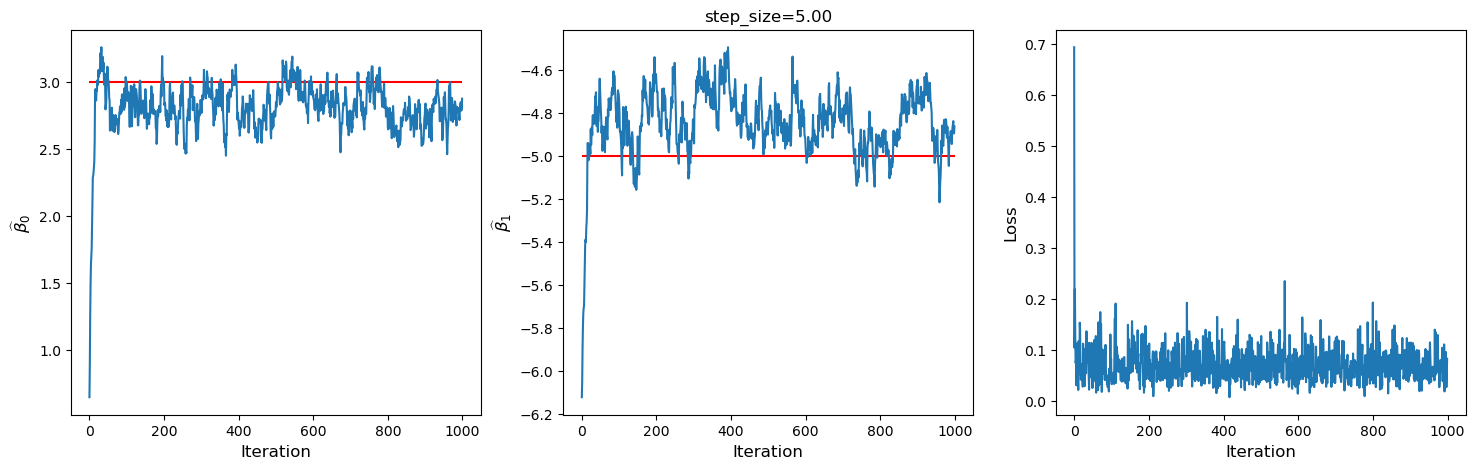

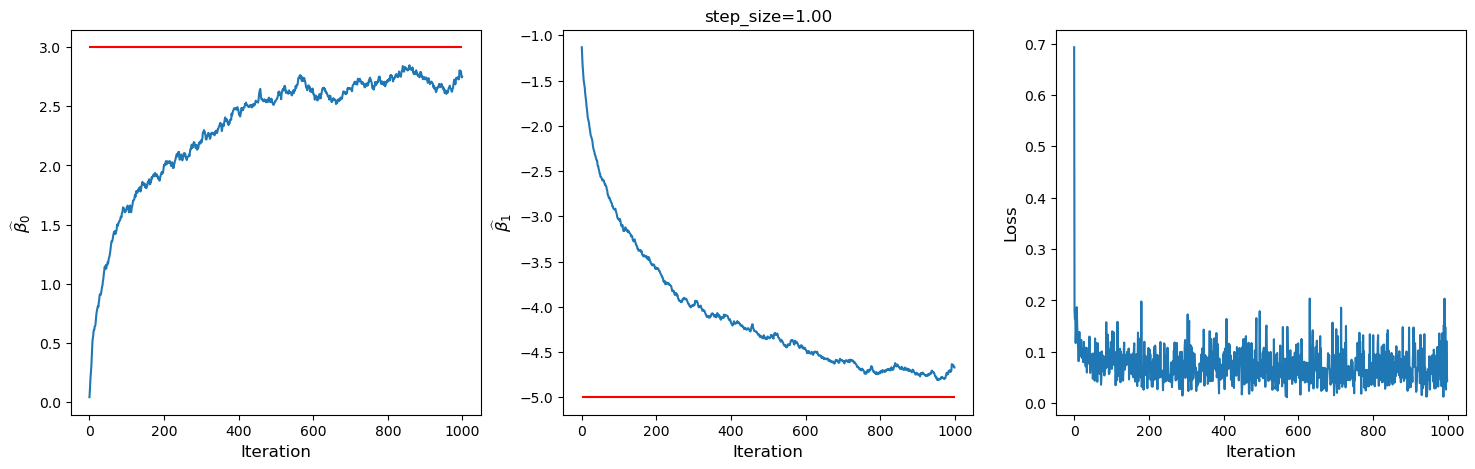

In [13]:
for step_size in [10, 5, 1]:
    _, _, beta0_all, beta1_all, loss_all = minibatch_grad_descent(batch_size=100, step_size=step_size)
    plot_betas_and_loss(beta0_all, beta1_all, loss_all, title = 'step_size=%.2f' % step_size)

The step size or learning rate defines how much the parameters are updated after each iteration step during the training process. A smaller step size (in this case $\eta$ = 1), will require more iterations until convergence, as only smaller changes are made to the parameters after each iteration step. The smaller step size is also clearly visible on the plot, as the iteration curve is more stable and shows less fluctuations. A danger, however, of a too small step size is that the learning process can get stuck, leading to a failure to train. 

A larger step size leads to rapid changes and more fluctuations in between the iteration steps. This is also visible on the plots, where the highest step size ($\eta$ = 10) gives the most fluctuations (the latter would be more clear if the vertical axes had the same scale). In general, less iterations are required for the solution to converge. A danger, however, of choosing a too high step size is that it can cause the model to converge too quickly, leading to a suboptimal solution.

The run with the smallest step size ($\eta$ = 1) has not converged yet. This is because only smaller changes are made to the parameters after each iteration step. As a consequence, more iterations are necessary for the solution to converge.

If the number of iterations would be fixed to 1000 and a choice has to be made between the three step sizes provided in this part of the exercise ($\eta$ = 1, $\eta$ = 5, and $\eta$ = 10), the optimal choice would be $\eta$ = 5 (according to the reasoning in the first part of this exercise). In general, two options are available: increase the step size or increase the number or iterations. A higher step size requires more iterations, while a smaller step size requires fewer iterations.

If one could choose the value for $\eta$ and the number of iterations, a good estimate would be to put the number of iterations to 1000 and the step size $\eta$ to 3, as 10 and 5 are too big, while 1 is too small. The mini batch size m will be set equal to 1000 and the regularization parameter equal to zero (no regularization). To obtain the final parameter estimates for $\beta_0$ and $\beta_1$, it would be beneficial to repeat the full algorithm a number of times and calculate the mean, similar to what is done in part d of the exercise. The amount of runs will depend on the computational cost of the algorithm. 